In [110]:
#BRIEF:  
#- Applied `StandardScaler` to normalize SO₂ and NO₂ values.
#- Used `fit_transform()` on training data and `transform()` on test data to prevent data leakage.
#- Trained a Linear Regression model and evaluated it using R² and MSE.
#- Saved the model and scaler for deployment in Week 3.

In [111]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import joblib


import sys
import os

sys.path.append(os.path.abspath(".."))  # Adds project root to Python path
sys.path.append(os.path.abspath("."))  # Adds current directory to Python path



In [112]:
# Load Dataset
df = pd.read_csv("../WEEK1/data/data.csv", encoding='ISO-8859-1', engine='python')
df.head()


,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


In [113]:
# Initial Exploration (Basic Data Exploration)
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435742 entries, 0 to 435741
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   stn_code                     291665 non-null  object 
 1   sampling_date                435739 non-null  object 
 2   state                        435742 non-null  object 
 3   location                     435739 non-null  object 
 4   agency                       286261 non-null  object 
 5   type                         430349 non-null  object 
 6   so2                          401096 non-null  float64
 7   no2                          419509 non-null  float64
 8   rspm                         395520 non-null  float64
 9   spm                          198355 non-null  float64
 10  location_monitoring_station  408251 non-null  object 
 11  pm2_5                        9314 non-null    float64
 12  date                         435735 non-null  object 
dtyp

stn_code                       144077
sampling_date                       3
state                               0
location                            3
agency                         149481
type                             5393
so2                             34646
no2                             16233
rspm                            40222
spm                            237387
location_monitoring_station     27491
pm2_5                          426428
date                                7
dtype: int64

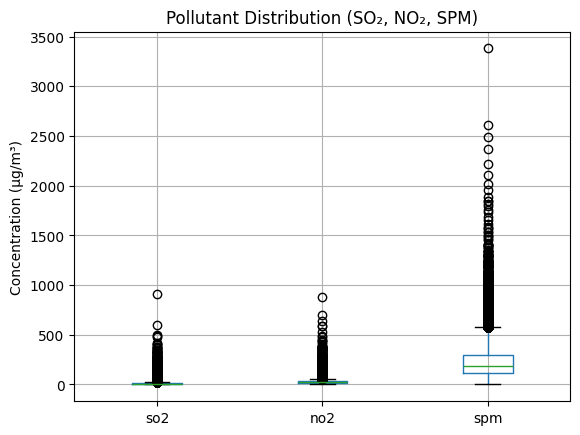

In [114]:
# Distribution of key pollutants

df[['so2', 'no2', 'spm']].boxplot()
plt.title("Pollutant Distribution (SO₂, NO₂, SPM)")
plt.ylabel("Concentration (µg/m³)")
plt.grid(True)
plt.show()


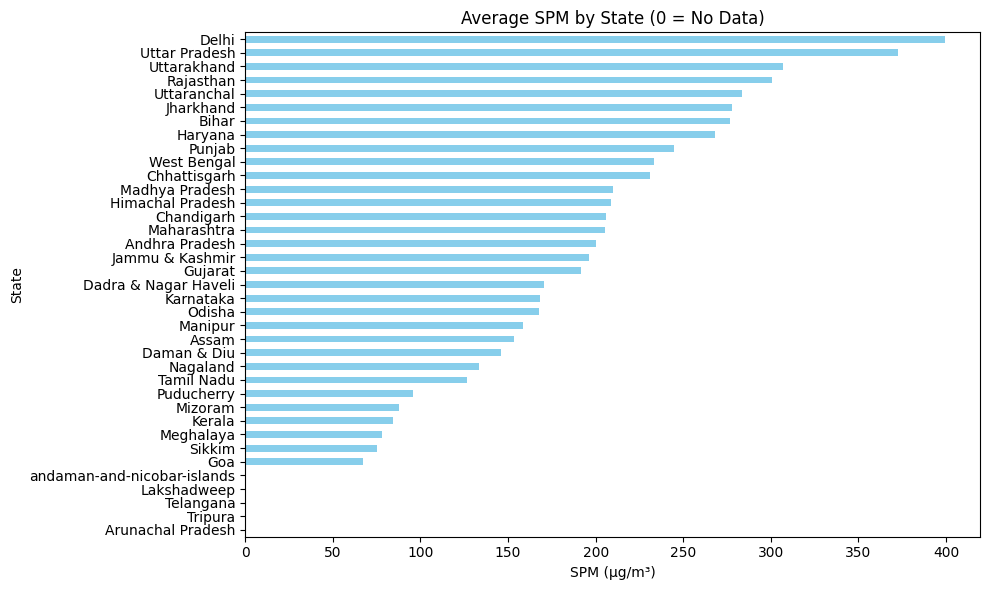

In [115]:
# Average SPM by State
spm_by_state = df.groupby('state')['spm'].mean()
spm_by_state = spm_by_state.fillna(0)  # Replace NaN with 0 for plotting

spm_by_state.sort_values().plot(kind='barh', figsize=(10,6), color='skyblue')
plt.title("Average SPM by State (0 = No Data)")
plt.xlabel("SPM (µg/m³)")
plt.ylabel("State")
plt.tight_layout()
plt.show()


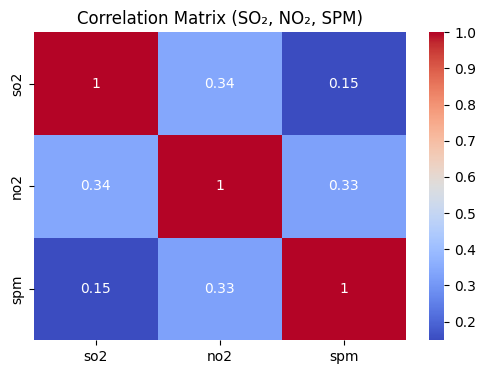

In [116]:
# Correlation Heatmap

plt.figure(figsize=(6,4))
sns.heatmap(df[['so2', 'no2', 'spm']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix (SO₂, NO₂, SPM)")
plt.show()


In [117]:
# Custom parser for 'February - M021990' format
def parse_custom_date(val):
    try:
        month_str, code = val.split(" - ")
        month_num = int(code[1:3])  # Extract '02' from 'M021990'
        year = int(code[3:])        # Extract '1990' from 'M021990'
        return pd.Timestamp(year=year, month=month_num, day=1)
    except:
        return pd.NaT

In [118]:
# Apply parser
df['sampling_date'] = df['sampling_date'].apply(parse_custom_date)

# Drop rows with invalid dates or missing SPM
df = df.dropna(subset=['sampling_date', 'spm'])


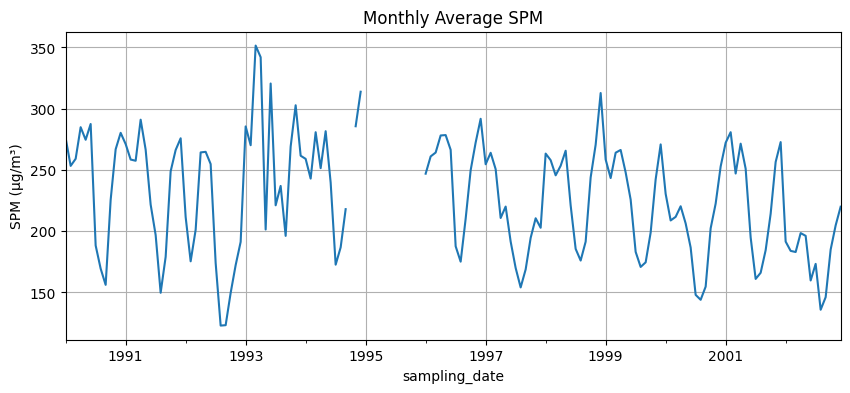

In [119]:
# Time Series Plot
df.set_index('sampling_date')['spm'].resample('ME').mean().plot(figsize=(10,4))
plt.title("Monthly Average SPM")
plt.ylabel("SPM (µg/m³)")
plt.grid(True)
plt.show()


In [120]:
## Preprocessing + Model Training

# Select features and target
df_model = df[['so2', 'no2', 'spm']].dropna()
X = df_model[['so2', 'no2']]
y = df_model['spm']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # fit + transform
X_test_scaled = scaler.transform(X_test)        # only transform

# Train model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.2f}")


R² Score: 0.0688
Mean Squared Error: 21228.91


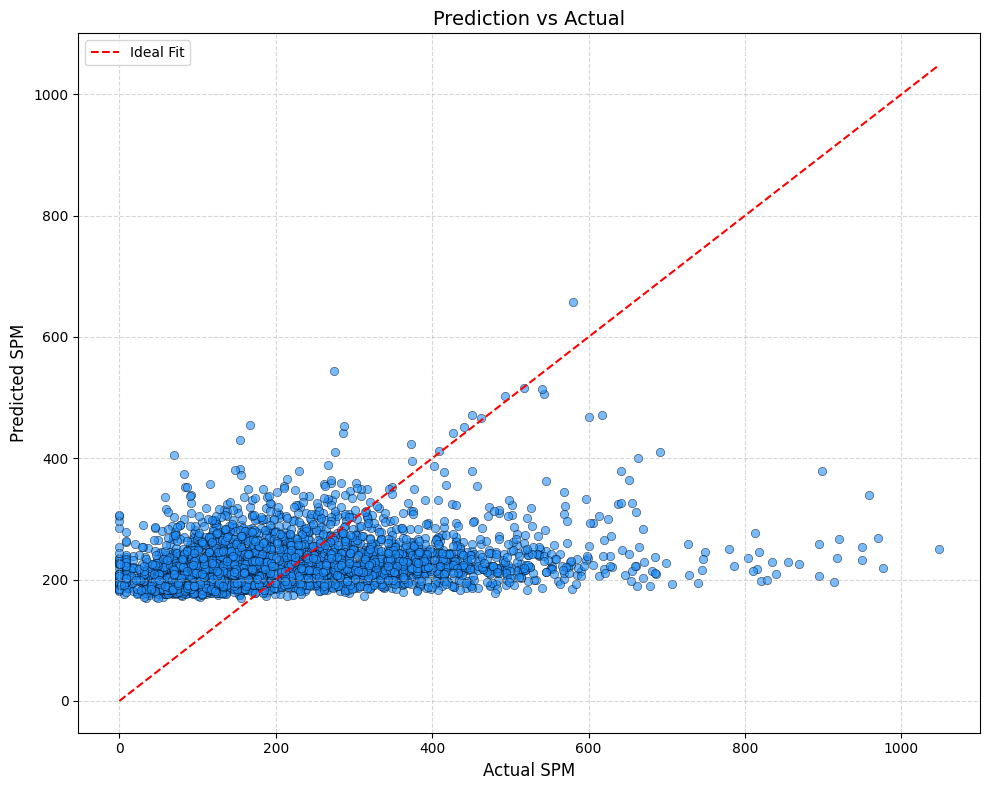

In [121]:
## Prediction vs Actual Plot

plt.figure(figsize=(10,8))  # Bigger canvas
plt.scatter(y_test, y_pred, alpha=0.6, color='dodgerblue', edgecolors='k', linewidths=0.5)
plt.xlabel("Actual SPM", fontsize=12)
plt.ylabel("Predicted SPM", fontsize=12)
plt.title("Prediction vs Actual", fontsize=14)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Fit')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [122]:
## Save model and scaler

joblib.dump(model, "../WEEK2/linear_regression_model.pkl")
joblib.dump(scaler, "../WEEK2/scaler.pkl")
print("Model and scaler saved successfully.")


Model and scaler saved successfully.
